# Validation, Regularisation and Callbacks

## Coding tutorials
#### [1. Validation sets](#coding_tutorial_1)
#### [2. Model regularisation](#coding_tutorial_2)
#### [3. Introduction to callbacks](#coding_tutorial_3)
#### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.tanh))
model.add(tf.keras.layers.Dense(units=2))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

history = model.fit(x=inputs, y=targets, validation_split=0.2, verbose=0)

# dict_keys(['loss', 'mape', 'val_loss', 'val_mape'])
print(history.history.keys())

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
    verbose=0)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
    verbose=0)

#### Load the data

In [1]:
from sklearn.datasets import load_diabetes

# Load the diabetes dataset
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])
print('\n', diabetes_dataset.keys())

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [2]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

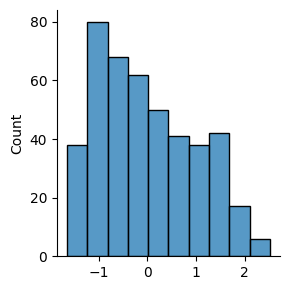

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Normalise the target data will make clearer training curves
targets = (targets - targets.mean(axis=0)) / targets.std()

sns.displot(x=targets, height=3)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train target shape: {train_targets.shape}")
print(f"Test target shape: {test_targets.shape}")

Train data shape: (397, 10)
Test data shape: (45, 10)
Train target shape: (397,)
Test target shape: (45,)


#### Train a feedforward neural network model

In [15]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# Build the model
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu,
        input_shape=(train_data.shape[1],)))
    for _ in range(5):
        model.add(tf.keras.layers.Dense(units=128,
            activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(units=1))
    
    return model

# Build model
model = get_model()
# Print the model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               1408      
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 1)                

In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

#### Plot the learning curves

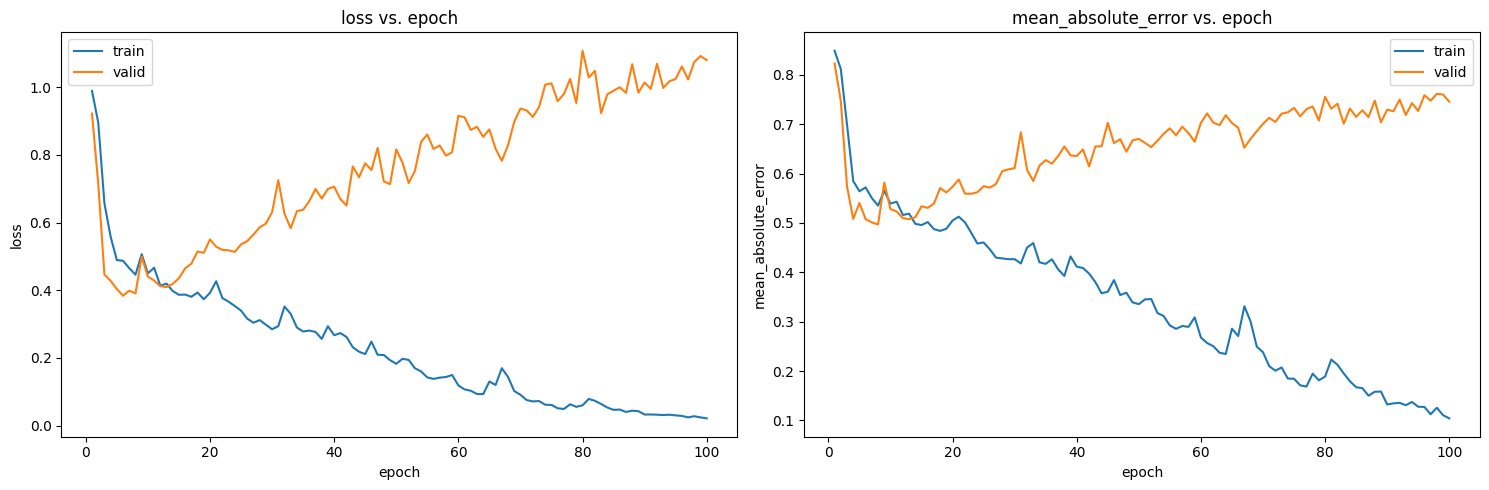

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the model, with some of the data reserved for validation
history = model.fit(x=train_data, y=train_targets, validation_split=0.15, 
    epochs=100, batch_size=64, verbose=0)

# Plot the training and validation metrics
df_history = pd.DataFrame(data=history.history, index=history.epoch)
metrics = ['loss', 'mean_absolute_error']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metric in zip(axes, metrics):
    sns.lineplot(ax=ax, data=df_history, label='train',
        x=df_history.index+1, y=metric)
    try:
        sns.lineplot(ax=ax, data=df_history, label='valid',
            x=df_history.index+1, y=f'val_{metric}')
    except Exception:
        pass
    ax.legend(loc='best')
    ax.set_xlabel(xlabel='epoch')
    ax.set_ylabel(ylabel=f'{metric}')
    ax.set_title(label=f'{metric} vs. epoch')
fig.tight_layout()
plt.show()

In [18]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x=test_data, y=test_targets,
    verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(test_loss, test_mae))

Test loss: 1.006
Test MAE: 0.778


***
<a id="coding_tutorial_2"></a>
## Model regularisation

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.001),
    bias_regularizer=tf.keras.regularizers.l2(l2=0.001)))
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.BinaryAccuracy()])

model.fit(x=inputs, y=targets, validation_split=0.25, verbose=0)

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

# Training mode, with dropout
model.fit(x=inputs, y=targets, validation_split=0.25, verbose=0)
# Testing mode, no dropout
model.evaluate(x=val_inputs, y=val_targets, verbose=0)
# Testing mode, no dropout
model.predict(x=test_inputs, verbose=0)

#### Load the data

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
diabetes_dataset = load_diabetes()
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']
# Normalise the target data will make clearer training curves
targets = (targets - targets.mean(axis=0)) / targets.std()

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train target shape: {train_targets.shape}")
print(f"Test target shape: {test_targets.shape}")

Train data shape: (397, 10)
Test data shape: (45, 10)
Train target shape: (397,)
Test target shape: (45,)


#### Adding regularisation with weight decay and dropout

In [5]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

def get_regularised_model(wd, rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu, 
        kernel_regularizer=tf.keras.regularizers.l2(l2=wd),
        input_shape=(train_data.shape[1],)))
    model.add(tf.keras.layers.Dropout(rate=rate))
    for _ in range(5):
        model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu, 
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd)))
        model.add(tf.keras.layers.Dropout(rate=rate))
    model.add(tf.keras.layers.Dense(units=1))
    
    return model

# Re-build the model with weight decay and dropout layers
model = get_regularised_model(wd=1e-5, rate=0.3)
print(model.summary())

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               1408      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

#### Plot the learning curves

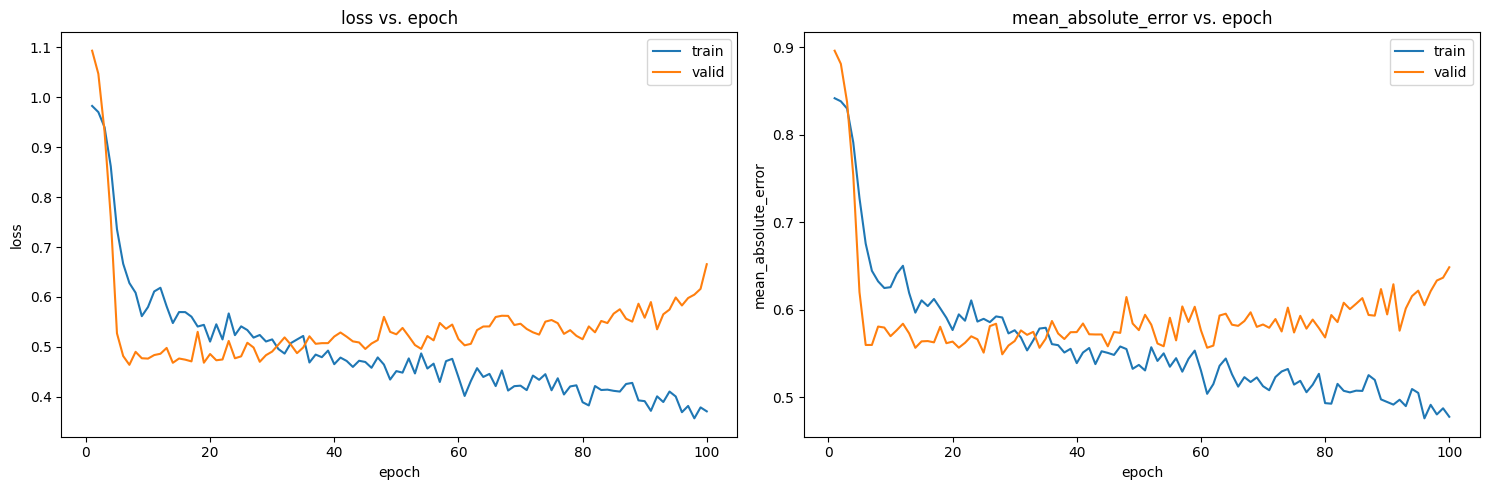

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the model, with some of the data reserved for validation
history = model.fit(x=train_data, y=train_targets, validation_split=0.15,
    epochs=100, batch_size=64, verbose=0)

# Plot the training and validation metrics
df_history = pd.DataFrame(data=history.history, index=history.epoch)
metrics = ['loss', 'mean_absolute_error']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metric in zip(axes, metrics):
    sns.lineplot(ax=ax, data=df_history, label='train',
        x=df_history.index+1, y=metric)
    try:
        sns.lineplot(ax=ax, data=df_history, label='valid',
            x=df_history.index+1, y=f'val_{metric}')
    except Exception:
        pass
    ax.legend(loc='best')
    ax.set_xlabel(xlabel='epoch')
    ax.set_ylabel(ylabel=f'{metric}')
    ax.set_title(label=f'{metric} vs. epoch')
fig.tight_layout()
plt.show()

In [7]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x=test_data, y=test_targets, verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(test_loss, test_mae))

Test loss: 0.491
Test MAE: 0.564


***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

class my_callback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        # Do something at the start of training
        
    def on_train_batch_begin(self, batch, logs=None):
        # Do something at the start of every batch iteration
        
    def on_epoch_end(self, epoch, logs=None):
        # Do something at the end of every epoch
        
history = model.fit(x=X_train, y=y_train, 
    epochs=5, callbacks=[my_callback()], verbose=0
)

#### Load the data

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
diabetes_dataset = load_diabetes()
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']
# Normalize the target data will make clearer training curves
targets = (targets - targets.mean(axis=0)) / targets.std()

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train target shape: {train_targets.shape}")
print(f"Test target shape: {test_targets.shape}")

Train data shape: (397, 10)
Test data shape: (45, 10)
Train target shape: (397,)
Test target shape: (45,)


#### Build a regularized feedforward neural network model

In [7]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

def get_regularised_model(wd, rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(l2=wd),
        input_shape=(train_data.shape[1],)))
    model.add(tf.keras.layers.Dropout(rate=rate))
    for _ in range(5):
        model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu,
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd)))
        model.add(tf.keras.layers.Dropout(rate=rate))
    model.add(tf.keras.layers.Dense(units=1))

    return model

# Re-build the model
model = get_regularised_model(wd=1e-5, rate=0.3)
print(model.summary())

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               1408      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

#### Example training callback

In [5]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# Write a custom callback
class TrainingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished training!")

#### Train the model with the callback

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Finished epoch 2
Finished training!


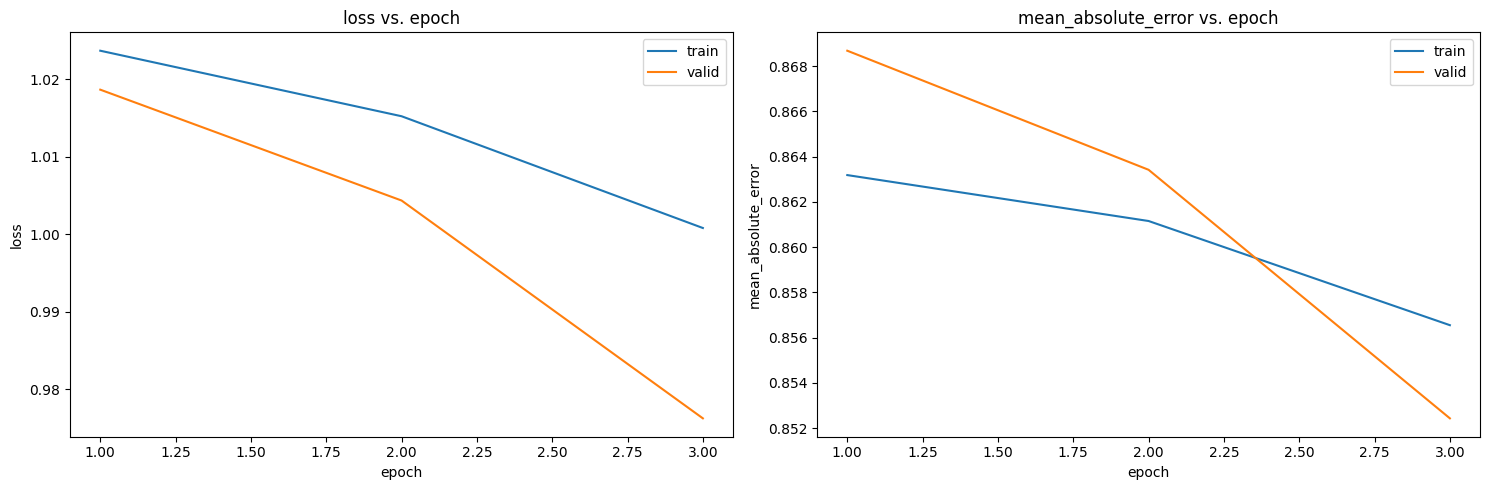

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the model, with some of the data reserved for validation
history = model.fit(x=train_data, y=train_targets, validation_split=0.15, 
    epochs=3, batch_size=128, callbacks=[TrainingCallback()],
    verbose=0)

# Plot the training and validation metrics
df_history = pd.DataFrame(data=history.history, index=history.epoch)
metrics=['loss', 'mean_absolute_error']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metric in zip(axes, metrics):
    sns.lineplot(ax=ax, data=df_history, label='train',
        x=df_history.index+1, y=metric)
    try:
        sns.lineplot(ax=ax, data=df_history, label='valid',
            x=df_history.index+1, y=f'val_{metric}')
    except Exception:
        pass
    ax.legend(loc='best')
    ax.set_xlabel(xlabel='epoch')
    ax.set_ylabel(ylabel=f'{metric}')
    ax.set_title(label=f'{metric} vs. epoch')
fig.tight_layout()
plt.show()

In [9]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# Write a custom callback
class TestingCallback(tf.keras.callbacks.Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing....")
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Finished testing!")

In [10]:
# Evaluate the model
test_loss, test_mae = model.evaluate(x=test_data, y=test_targets,
    callbacks=[TestingCallback()], verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(test_loss, test_mae))

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!
Test loss: 0.785
Test MAE: 0.746


In [11]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# Write a custom callback
class PredictionCallback(tf.keras.callbacks.Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction...")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")
        
    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [13]:
import numpy as np

# Make predictions with the model
preds =  model.predict(x=test_data,
    callbacks=[PredictionCallback()], verbose=0)
print(f"predictions: {np.squeeze(preds)}")

Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction!
predictions: [ 0.09746012  0.11249054  0.03290937 -0.01934442  0.02573613  0.07941051
  0.07335185 -0.02385945  0.09066202  0.00054634  0.00379546  0.10062762
 -0.00214851  0.04862291  0.11560218  0.12878934  0.00547393  0.10159645
  0.10231538 -0.00999221 -0.01779828  0.08232631  0.01092594 -0.01891354
  0.03761042  0.09421388  0.10670692  0.13422632  0.13009635 -0.01249787
 -0.00759849  0.0267004   0.03970964  0.08276999 -0.01037544 -0.01161687
 -0.01224713  0.13347845  0.0954761  -0.01357143 -0.00783813  0.00385623
  0.07715251 -0.0144567   0.01014006]


***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
        activation='relu', input_shape=(128, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss'
    monitor='val_accuracy',
    patience=5,
    min_delta=0.01,
    mode='max'
)

model.fit(X_train, y_train, validation_split=0.2, 
    epochs=100, callbacks=[early_stopping]
)

#### Re-train the models with early stopping

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               1408      
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dense_34 (Dense)            (None, 1)                

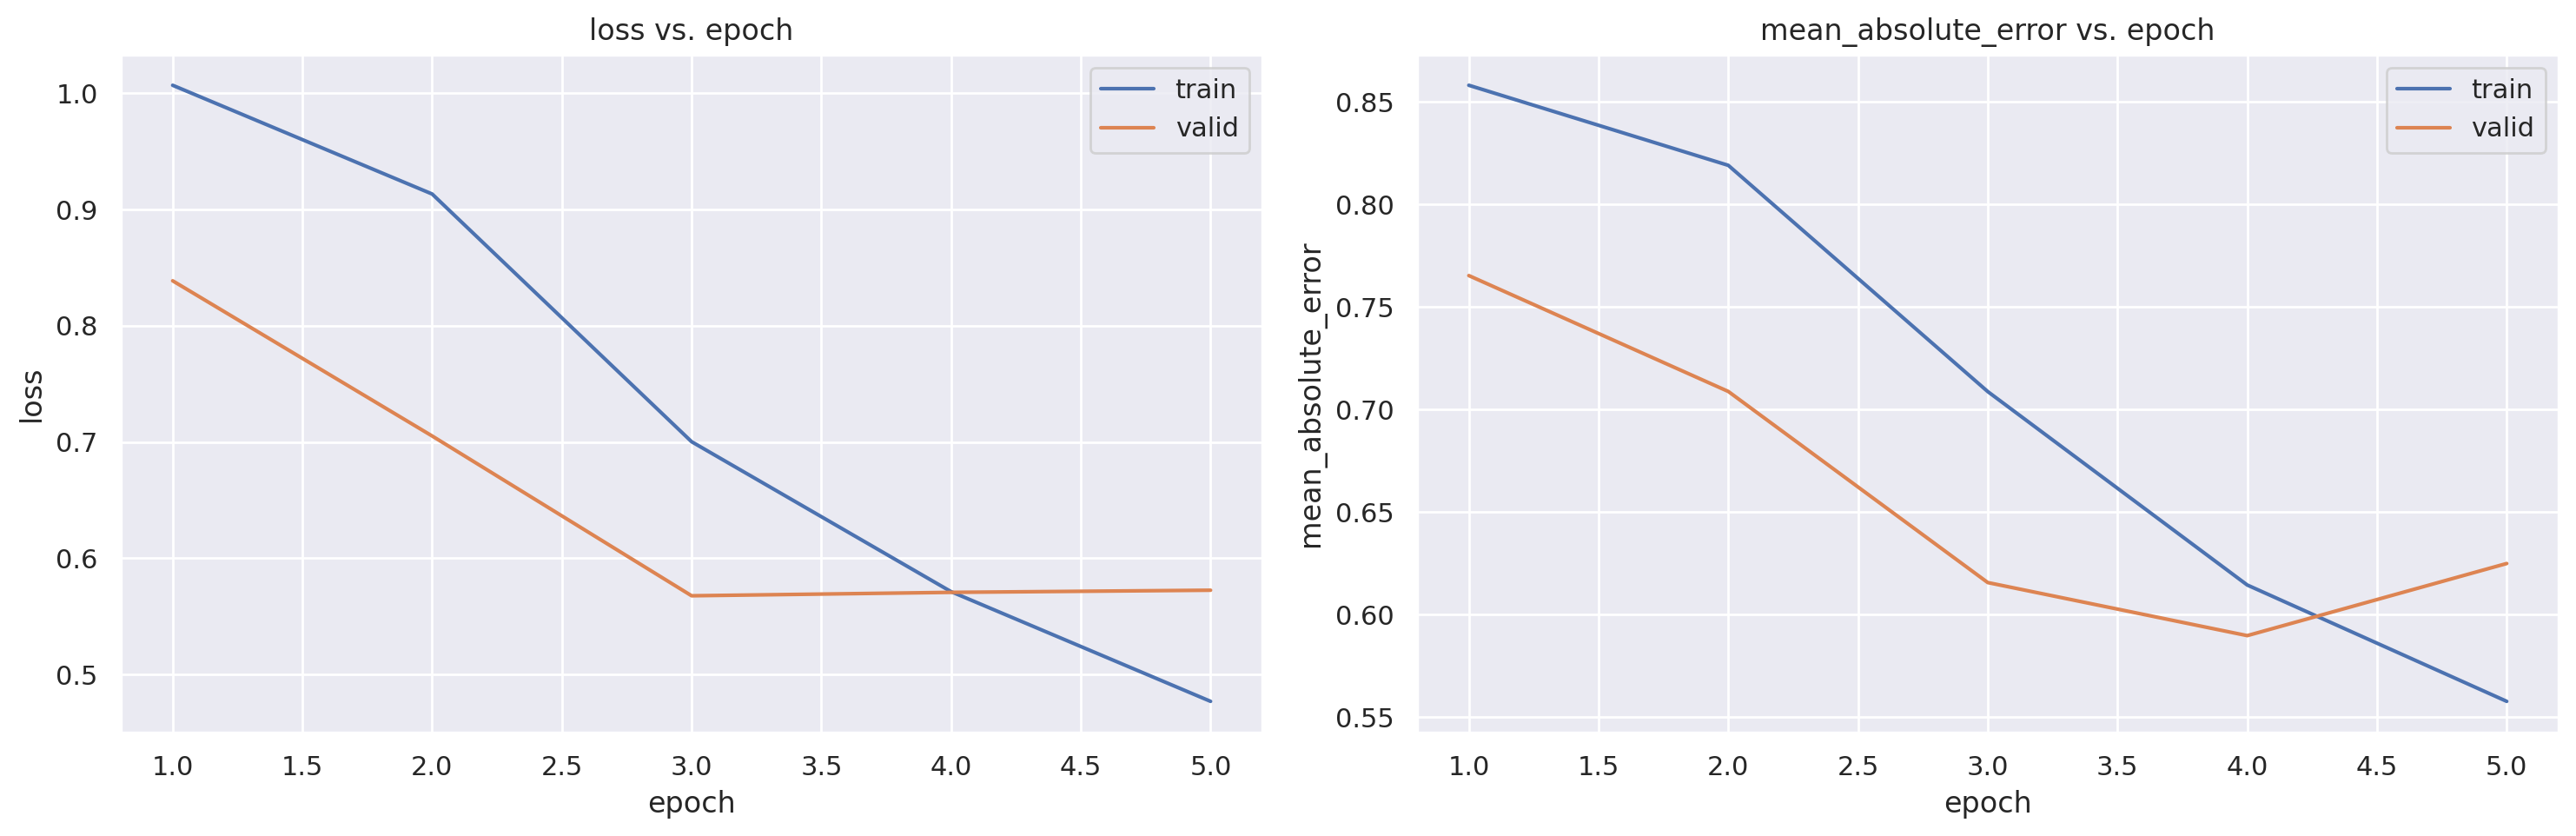

Test loss: 0.464
Test MAE: 0.539


In [25]:
# Re-train the unregularized model
unregularised_model = get_model(input_shape=(train_data.shape[1],))
# Print the model summary
print(unregularised_model.summary())

# Compile the model
compile_model(unregularised_model)
print(unregularised_model.loss)
print(unregularised_model.optimizer)
print(unregularised_model.metrics)

# Train the model, with some of the data reserved for validation
unreg_history = unregularised_model.fit(train_data, train_targets, 
    validation_split=0.15, batch_size=64, epochs=100, verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
)
# Plot training history
PlotHistory(unreg_history, metrics=['loss', 'mean_absolute_error']).plot()

# Evaluate the model on the test set
test_loss, test_mae = unregularised_model.evaluate(test_data, test_targets,
    verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(
    test_loss, test_mae))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               1408      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)              

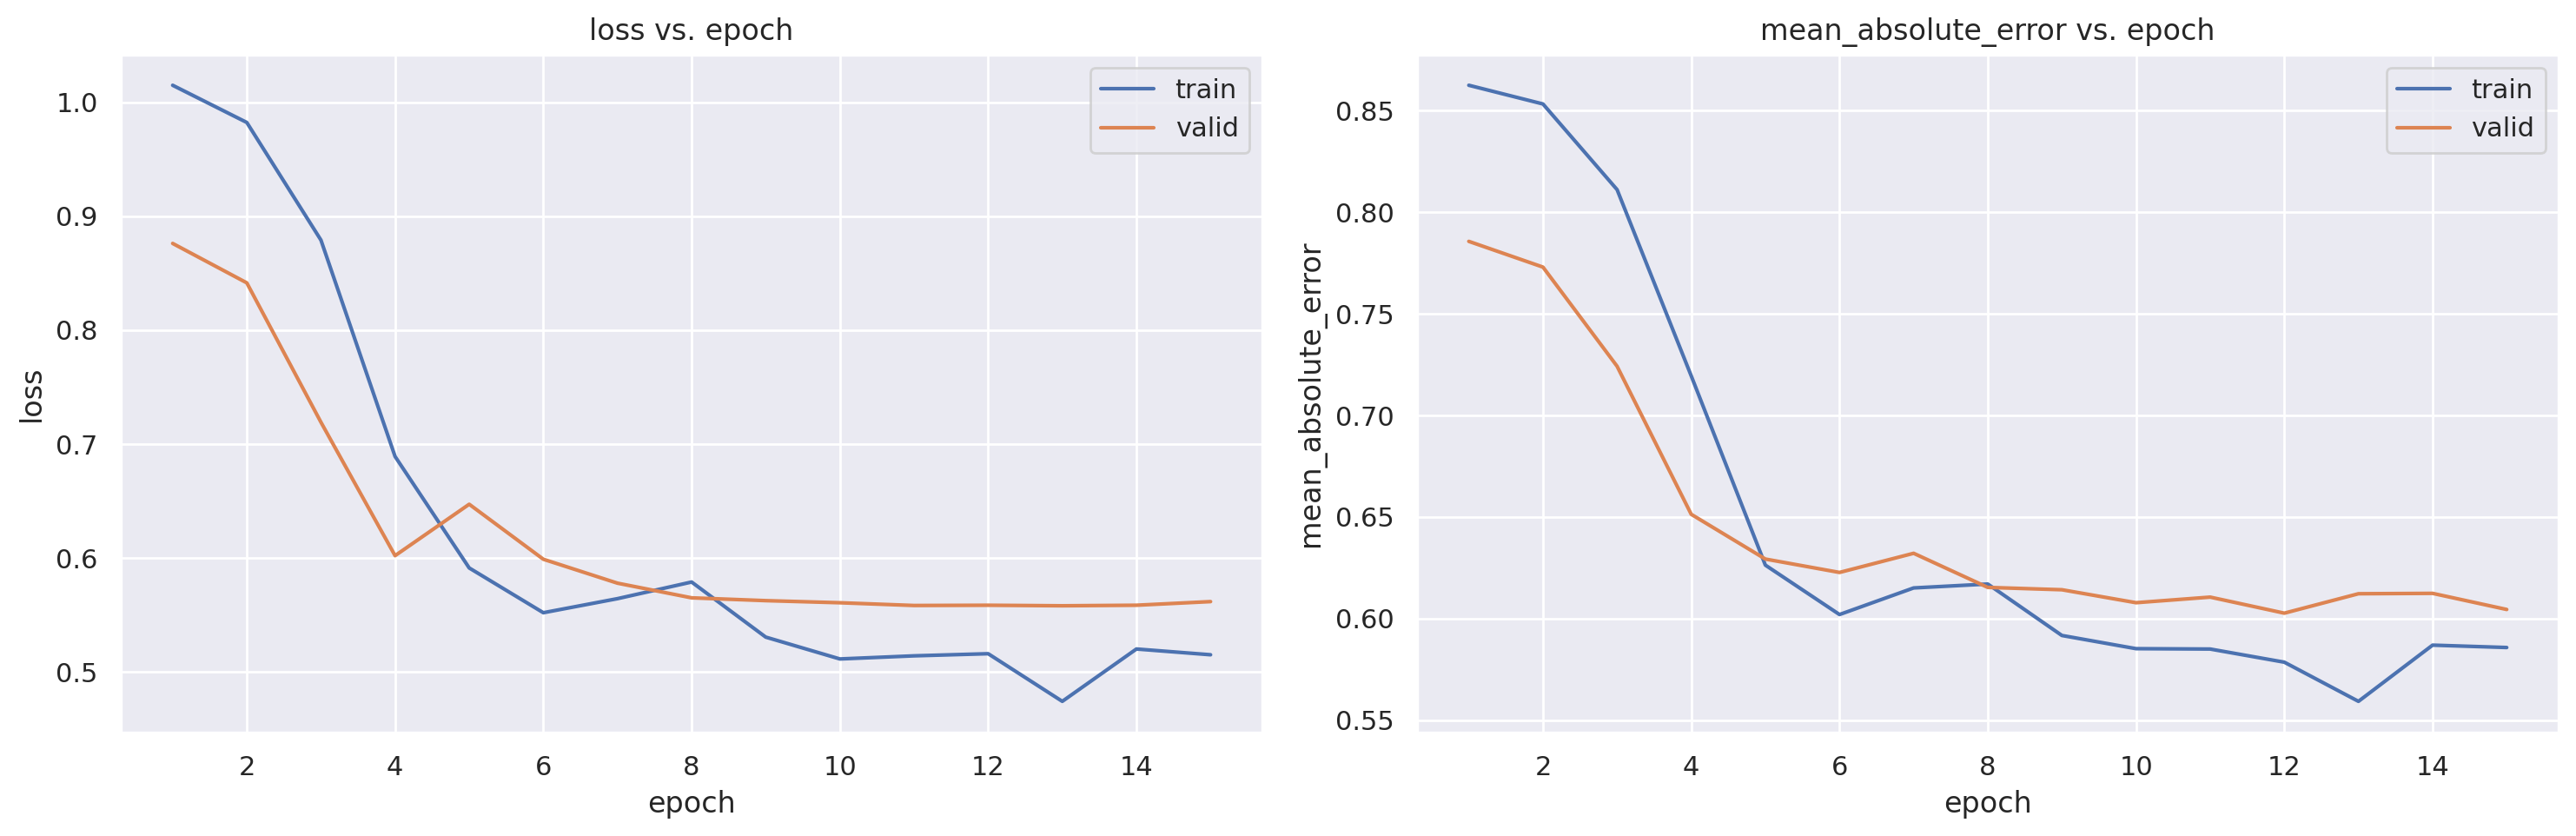

Test loss: 0.347
Test MAE: 0.465


In [26]:
# Re-train the regularised model
regularised_model = get_regularised_model(input_shape=(train_data.shape[1],),
    wd=1e-8, rate=0.2)
# Print the model summary
print(regularised_model.summary())

# Compile the model
compile_model(regularised_model)
print(regularised_model.loss)
print(regularised_model.optimizer)
print(regularised_model.metrics)

# Train the model, with some of the data reserved for validation
reg_history = regularised_model.fit(train_data, train_targets, 
    validation_split=0.15, batch_size=64, epochs=100, verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
)
# Plot training history
PlotHistory(reg_history, metrics=['loss', 'mean_absolute_error']).plot()

# Evaluate the model on the test set
test_loss, test_mae = regularised_model.evaluate(test_data, test_targets,
    verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(
    test_loss, test_mae))

#### Plot the learning curves

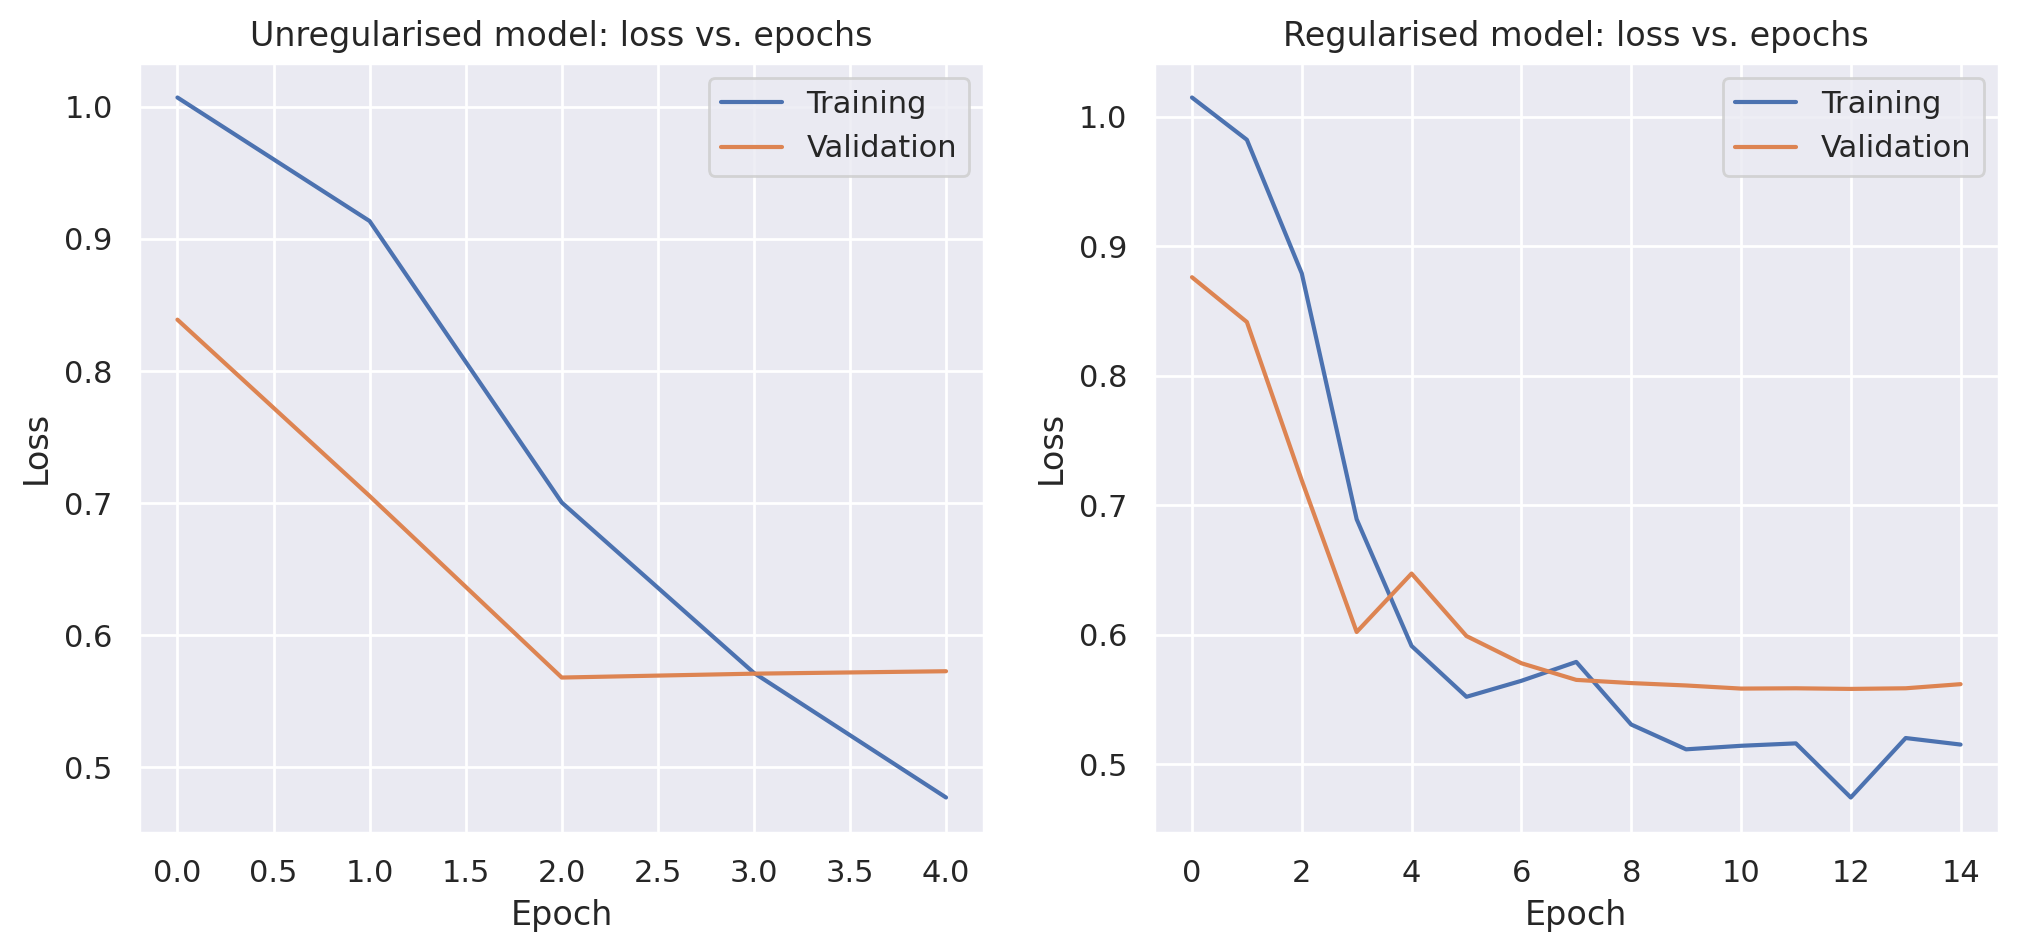

In [27]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()